In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F
%matplotlib inline
import os

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder("/content/drive/MyDrive/project", transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

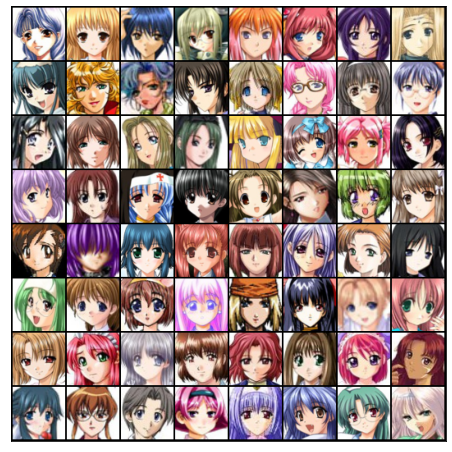

In [ ]:
show_batch(train_dl)

 **USING GPU**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

**DISCRIMINATOR NETWORK**

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16
     nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

**GENERATOR NETWORK**

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


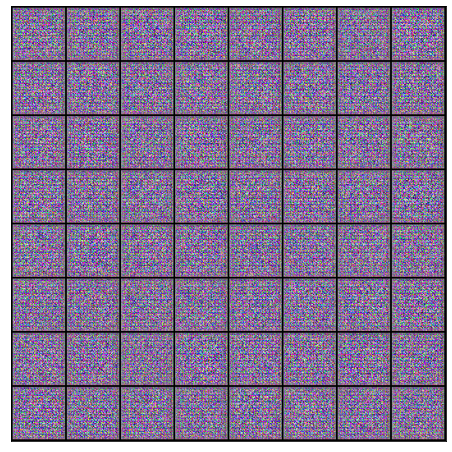

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

**Discriminator Training**

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

**Generator Training**

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
def show_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

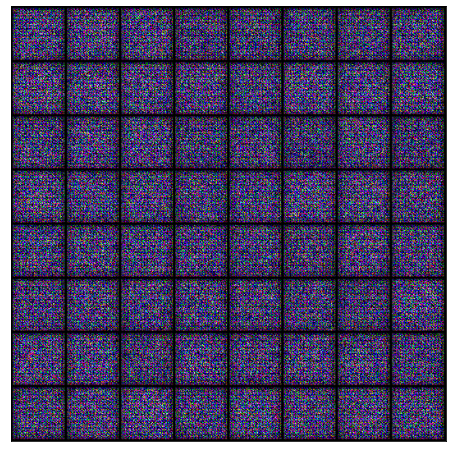

In [ ]:
show_samples(0, fixed_latent)

**Full Training Loop**

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs, lr)


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 14.1936, loss_d: 0.3903, real_score: 0.9524, fake_score: 0.2645


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 2.8806, loss_d: 0.5517, real_score: 0.6811, fake_score: 0.0176


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 3.6539, loss_d: 0.3447, real_score: 0.8264, fake_score: 0.0754


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 5.0630, loss_d: 0.4791, real_score: 0.8066, fake_score: 0.1939


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.4814, loss_d: 0.7123, real_score: 0.7195, fake_score: 0.2399


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 4.2761, loss_d: 0.6676, real_score: 0.7399, fake_score: 0.2288


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 3.2752, loss_d: 0.8115, real_score: 0.6314, fake_score: 0.1597


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.8791, loss_d: 0.3611, real_score: 0.8580, fake_score: 0.1386


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 2.6442, loss_d: 0.3167, real_score: 0.8128, fake_score: 0.0795


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 6.3824, loss_d: 0.8134, real_score: 0.9260, fake_score: 0.4560


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 8.9062, loss_d: 1.0968, real_score: 0.9681, fake_score: 0.6195


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 2.9476, loss_d: 0.2996, real_score: 0.8186, fake_score: 0.0521


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 9.4631, loss_d: 1.1622, real_score: 0.9803, fake_score: 0.6153


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 4.7867, loss_d: 0.5393, real_score: 0.6607, fake_score: 0.0299


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 2.9645, loss_d: 0.2493, real_score: 0.9133, fake_score: 0.1342


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.5810, loss_d: 0.3820, real_score: 0.8342, fake_score: 0.1580


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 4.2682, loss_d: 0.4603, real_score: 0.8391, fake_score: 0.1865


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 6.2110, loss_d: 0.1932, real_score: 0.9497, fake_score: 0.1236


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 5.1595, loss_d: 1.5370, real_score: 0.3213, fake_score: 0.0021


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 5.8418, loss_d: 0.5943, real_score: 0.6351, fake_score: 0.0089


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 3.9864, loss_d: 0.8705, real_score: 0.5411, fake_score: 0.0093


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 4.9912, loss_d: 0.4410, real_score: 0.8840, fake_score: 0.2402


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 5.7874, loss_d: 2.8067, real_score: 0.1396, fake_score: 0.0003


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 5.2871, loss_d: 0.4451, real_score: 0.8183, fake_score: 0.1726


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 5.4343, loss_d: 0.3830, real_score: 0.8367, fake_score: 0.1433


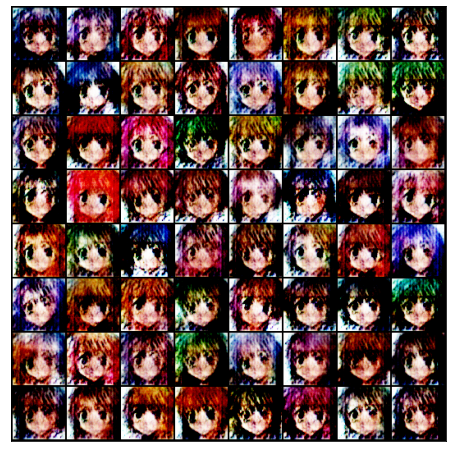

In [ ]:
show_samples(0, fixed_latent)


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

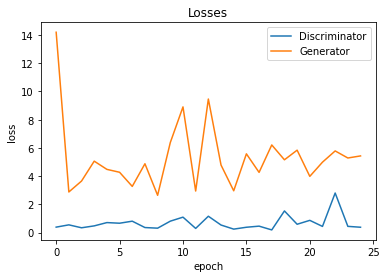

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

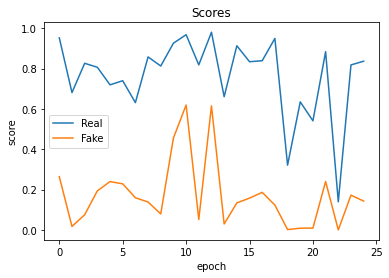

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');